In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
import seaborn as sn
import pandas as pd
import imp
import pymc3 as pm
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

sn.set_context('talk')

In [2]:
# Optionally suppress warnings in the final version of the notebook
import warnings
warnings.filterwarnings('ignore')

# ECOREG full analysis (part 3: relationships)

This notebook follows on from the work described [here](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb) and [here](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb). In the first notebook, PCA was used to identify a subset of potentially interesting parameters with reduced collinearity; in the second, potentially interesting patterns highlighted by the PCA were explored by testing for differences between regulated and unregulated sites. In this notebook, I want to explore regression relationships between the variables, following up on hypotheses developed in notebooks 1 and 2.

In [3]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)
hi_df = hi_df.query('(eco_dataset == "pb") and (time_per == 3)')

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

In [4]:
# Import custom functions
func_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Python\ECOREG\ecoreg_code.py'

ecoreg = imp.load_source('ecoreg_code', func_path)

## 6. Relationships to explore

Based on the results in the previous two notebooks, it seems reasonable to concentrate on the following reduced set of response and explanatory variables for Germany:

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/regression_metrics_ger.png?raw=true" alt="German regression metrics" width="400">

and these for Norway:

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/regression_metrics_nor.png?raw=true" alt="German regression metrics" width="450">

In each case, these variables have been selected because either: 

 1. They are broadly representative of the principal components in the ecology, water quality or hydrology datasets ([notebook 1](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb)), and/or <br><br>
 
 2. They show potentially interesting differences between regulated and unregulated sites ([notebook 2](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb)).
 
(The parameters shown in bold in the tables above are those that I consider to be the most promising based on my work so far). 

The aim of this notebook is to explore regression relationships between these variables. 

## 7. Regression approaches

Despite the data exploration and dimensionality reduction in the previous two notebooks, we still have a reasonably large number of response and explanatory variables. Furthermore, we are primarily interested in identifying and understanding the key relationships between these variables, rather than just making predictions for future outcomes. For this reason, it is important that the statistical models created are interpretable (at least to some extent), rather than being mysterious "black boxes".

Modern statistical techniques such as regression trees, neural networks etc. have the ability to deal well with non-linear relationships, and they often have excellent predictive performance too. Unfortunately, they are also generally difficult to interpret, and for this reason I have **restricted this analysis to linear models only** (time is tight and linear models are complicated enough!). In reality, the relationships in our data are unlikely to be linear, but I hope there will be some interesting patterns to discover nevertheless.

Even considering a very restricted set of candidate model structures, the problem of variable selection to identify "scientifically significant" relationships is still very challenging and I have never really found a satisfactory approach. In this notebook I'll try a number of different methods in an attempt to build up a consistent picture. I'm not sure whether this workflow is well established, but I believe it should be reasonably robust. My method is as follows:

 1. Use the best fitting **lasso model** (obtained via cross-validation), together with an exploration of the **lasso path**, to understand the most important relationships in the dataset. Note that the lasso model must be estimated using **standardised** varaibles. (An excellent description of how to interpret the lasso path can be found [here](http://stats.stackexchange.com/a/154853/5467)). <br><br>
 
 2. Use the results from (1) to guide construction of a few relevant OLS models using the non-standardized (and therefore easier to interpret) values. <br><br>
 
 3. Use **best subsets** regression to identify the model with the lowest BIC of all the models under consideration. Note that, like stepwise regression, this basically amounts to "data dredging" and therefore cannot be taken too seriously. On the other hand, these techniques are widely used, so they make a useful comparison.

**Note:** Best subsets and stepwise regression techniques are used widely in the ecological literature. Large numbers of different models are tested iteratively in an attempt to identify the "best" (where "best" is often defined as the model with the lowest AIC or BIC). In the context of "significance" testing, these methods have been heavily criticised, because the p-values and parameter estimates obtained are essentially meaningless (see [notebook 1](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb) for more details). In essence, trying a very large number of different models is prone to "overfitting" for exactly the same reasons that very complex models are: we know that our measured dataset includes some random components, and if we try enough different models we'll eventually find one that just happens to fit well with the randomness in our data. We therefore observe excellent within-sample model performance, but we're actually fitting the noise rather than the signal, so the "best" model found by stepwise or best subsets methods will often perform poorly out-of-sample (i.e. it's not actually a good model at all). Simulation studies (where the true model is known exactly) have repeatedly shown that these technique can select completely the wrong model, even when the model assumptions (e.g. regarding the error structure) are properly satisfied.  

In most cases, best subsets and stepwise regression approaches are inappropriate and the recommended approach is instead to use some kind of **regularisation**, such as **ridge** regression or the **lasso**. Ridge regression has advantages when there are lots of collinear predictors, whereas the lasso incorporates "feature selection" characteristics that can be useful when the aim is to produce a parsimonious (i.e. "sparse") model, which may be eaiser to interpret. In [notebook 1](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb), I used PCA to reduce colinearity - the principal components are orthogonal and therefore by definition not collinear, so ridge regression should not be necessary. In actual fact, I haven't completely removed collinearity from our data, because I decided to work with the explanatory variables with the highest loading along each of the PCs, rather than with the PCs directly. Once again, this was done to make the output easier to interpret. Nevertheless, I hope to have reduced collinearity by a substantial degree, so I will therefore focus on the use of lasso regression for the purpose of variable selection and interpretation.

Finally, note that regularised regression has a natural interpretation within a Bayesian context: ridge regression is equivalent to using a Gaussian prior on the parameters, whereas lasso assumes a Laplace prior. For convenience, I am not explicitly formulating these regression within a Bayesian framework, but the work presented here is not incompatible with the Bayesian approach used in [notebook 2](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb).

The easiest way to introduce the regression workflow is with a detailed example (subsequent analyses will be presented more succinctly).

### 7.1. Example from Norway

#### 7.1.1. Number of MZB taxa

Begin by extracting a dataframe containing the response variable (`n_taxa`) and explanatory variables of interest (from the table for Norway above).

In [5]:
cols = ['n_taxa', 'tn', 'toc', 'cond', 'mean', 'range', 'max12', 
        'revs_per_yr', 'days_to_p95', 'days_to_max', 'max10', 
        'cv', 'country', 'regulated']
df = pd.concat([site_df, mzb_df, hi_df], axis=1)[cols]
df = df.query('country == "N"')

df.head()

,n_taxa,tn,toc,cond,mean,range,max12,revs_per_yr,days_to_p95,days_to_max,max10,cv,country,regulated
S109.2,20.0,0.285,0.85,52.2,31.613410,655.79835,17.27617,132.000000,84,828,33.35955,1.405250,N,1
S109.21,23.0,0.099,0.72,30.7,3.576798,49.58114,1.41556,138.333333,83,827,4.63132,1.340999,N,0
S109.9,24.0,0.054,0.69,36.2,19.490855,334.40153,5.01335,120.333333,83,827,26.58150,1.507076,N,0
S12.137,41.0,0.155,1.20,14.9,25.628777,214.85086,28.86813,176.333333,75,822,176.84978,0.914427,N,1
S12.200,34.0,0.255,2.70,31.5,25.806984,496.59644,15.78188,97.666667,25,111,128.84639,1.411023,N,1


##### Step 1: Plot the lasso path

In [6]:
# Lists of explan and resp vars
exp_vars = ['tn', 'toc', 'cond', 'mean', 'range', 'max12', 
            'revs_per_yr', 'days_to_p95', 'days_to_max', 
            'max10', 'cv']
resp_var = 'n_taxa'

# Plot lasso path
res_df, fig = ecoreg.plot_lasso_path(df, resp_var, exp_vars)

mpld3.display(fig)

This is a complicated plot, with some repeated colours. To identify which curve is which, hover the mouse pointer over the lines along the right-hand margin of the figure - "tooltip" labels should appear identifying each line.

The lasso is a form of **regularised regression**, which means a penalty is added which "shrinks" the regression coefficients towards zero (see [this notebook](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_prelim_analysis2.ipynb) for more details). The size of the regularisation penalty is controlled by *alpha*, which appears along the x-axis of the plot above (but it is rescaled as $-Log(alpha)$). Small values of $-Log(alpha)$ (the left side of the plot) correspond to very "heavy" regularisation, where all the parameter coefficents are forced to zero and the "best" model becomes the "null" model (i.e. a heavy penalty favours simpler models). As $-Log(alpha)$ becomes larger (moving rightwards on the x-axis), the regularisation becomes less severe and some of the parameter values for the best-fitting model become non-zero (i.e. the "best" model becomes more complex). At the extreme right edge of the plot, the regularisation penalty is very small, and the coefficient estimates approach those obtained using standard OLS regression.

As the alpha penalty is relaxed (reading from left to right), parameters that come into the model first can be interpreted as being more important (i.e. of having a stronger relationship to the response variable). What's more, the shape of the lasso path for each variable provides information regarding the collinearity between predictors.

The plot can be interpreted as follows:

 * The first variable to come into the model as the regularisation penalty is relaxed is `tn`. The coefficient value for `tn` is positive and it increases rapidly and remains high throughout the path, implying that `tn` is the most important variable (of those being considered), and that it is positively correlated with `n_taxa`. <br><br>

 * The next variable to enter the model (and therefore the next most important) is `cv`. The coefficient is negative and its magnitude also increases quite rapidly. This implies that more variable flow conditions have a negative effect on the number of MZB taxa. <br><br>

 * The next variable to enter the model is `cond`. However, note that when `cond` enters there is a sudden kink in the trace for `tn`. This implies that `tn` and `cond` are correlated with one another (i.e. they are collinear), so to some extent these two variables can substitute for one another in the model. From a phjysical perspective, it is not surprising that `tn` and `cond` are related. If we want to build a parsimonious model that is easier to interpret, we might therefore choose to keep `tn` but not `cond`, because `tn` has a stronger relationship with the response. <br><br>

 * The next variable to enter is `toc`. This may also have an effect on the trace for `tn` (suggesting more collinearity), but this isn't too obvious on this plot, so I'm tempted to keep `toc` in the model for now. <br><br>

 * The next parameter to enter is `days_to_max` which, perhaps surprisingly, has a negative coefficient. Shortly after this, `days_to_p95` enters with a positive coefficient. These are two very similar quantities and the fact they exhert influence in opposie directions seems dubious, and suggests we might be getting to the stage where the (increasingly complex) model is starting to fit noise in the data rather than a genuine signal. This may be an indication that it's time to stop adding variables. Note that I've excluded `days_to_max` and `days_to_p95` from the model for these reasons. <br><br>

 * For completeness, the next two parameters to enter are `revs_per_yr` and `mean`, the former entering with a negative coefficient and the latter with a positive one. This makes intuitive sense: larger rivers typically have more stable flow conditions (fewer reversals per year), and such stable conditions seem to favour more MZB taxa. However, the trace for `revs_per_yr` is broadly similar to that for `cv`, except the relationship is weaker. From a physical standpoint, both these metrics are indicators of flow variability, so I'm tempted to ignore `revs_per_yr` and keep `cv` in the model for further investigation.

Based on this, we can identify a more parsimonious model with just 4 explanatory variables. Let's look in more detail at the lasso paths for these.

In [7]:
# Lists of explan and resp vars
exp_vars = ['tn', 'cv', 'toc', 'mean']
resp_var = 'n_taxa'

res_df, fig = ecoreg.plot_lasso_path(df, resp_var, exp_vars)

mpld3.display(fig)

These paths are much smoother, but now that we're looking in more detail we can see an obvious kink in the `tn` trace (caused when `toc` enters the model), and a similar kink in `cv` (caused when `mean` enters the model). It looks as though there is collinearity here after all, so perhaps a better model still would be to drop `toc` and `mean` as well.

Overall, based on an analysis of the lasso paths, I conclude that:

 * `tn` is the explanatory variable with the strongest relationship to `n_taxa`: more N means more taxa. <br><br>
 
 * `cv` is also important: more variable flow conditions mean fewer taxa. <br><br>
 
 * Other variables - especially `toc` and `mean` - may also be important, but they appear to be significantly correlated with `tn` and `cv`, both of which are more strongly related to the response.
 
##### Step 2: Find the best lasso model 

We can use cross-validation to find the best value for alpha. The coefficients for this model give an indication of which variables are genuinely important. 

(Note that the function I've created for this calculation has a number of plotting options, only some of which are described below).

LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=False,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


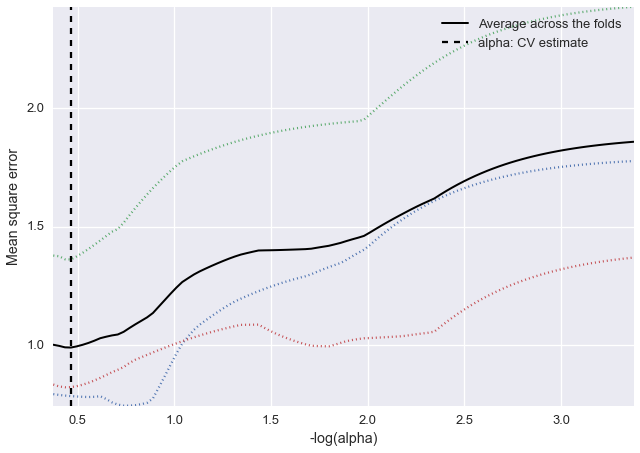

,0
tn,0.079675
toc,0.000000
cond,0.000000
mean,0.000000
range,-0.000000
max12,0.000000
revs_per_yr,-0.000000
days_to_p95,0.000000
days_to_max,-0.000000
max10,0.000000


In [8]:
# Lists of explan and resp vars
exp_vars = ['tn', 'toc', 'cond', 'mean', 'range', 'max12', 'revs_per_yr', 
            'days_to_p95', 'days_to_max', 'max10', 'cv']
resp_var = 'n_taxa'

params = ecoreg.best_lasso(df, resp_var, exp_vars, kcv=3, cv_path=True, hists=False)
params

The minimum of the thick black line on the plot above gives the optimum value for alpha. This is the value with the lowest mean squared error as estimated by three-fold cross-validation. With this value for alpha, **the best model includes only `TN`** - all the other coefficients are set to zero. This is consistent with the discussion above.

**Note:** We have a fairly limited dataset (only 40 sites in Norway), which makes meaningful k-fold cross-validation quite difficult. The best model seems quite sensitive to different choices of $k$, although the general picture is still consistent with the discussion of the lasso path above.

##### Step 3: Explore some OLS alternatives

OLS results are familar to most people and are easier to interpret, so it can be useful/reassuring to explore some OLS output as well. Here's a model including `tn` and `cv`, the two main parameters identifed from the lasso path.

In [9]:
mod_str = 'n_taxa ~ tn + cv'

# Regression. Pass alpha=0 for OLS. Larger alpha gives a bigger penalty on the
# size of the parameter estimates
model = smf.ols(mod_str, data=df).fit_regularized(alpha=0, l1_wt=0)

print model.summary()

                            OLS Regression Results                            
Dep. Variable:                 n_taxa   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     5.776
Date:                Tue, 07 Mar 2017   Prob (F-statistic):            0.00656
Time:                        12:04:52   Log-Likelihood:                -140.50
No. Observations:                  40   AIC:                             287.0
Df Residuals:                      37   BIC:                             292.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     28.1734      6.106      4.614      0.0

This is pretty consistent with the lasso results: the overall model is highly significant (`Prob (F-statistic) = 0.007`), as is the p-value for `tn` (0.008). The p-value for `cv` is also quite small, but not quite significant at p < 0.05.

Repeating the above for a simplified model (`n_taxa ~ tn`) gives a more significant result still, and the BIC decreases to 291.4, implying that the single variable model is (marginally) better. This is the same as the result obtained using the (better and more robust) lasso approach with cross-validation. However, one advantage of the OLS output is that it uses the original data units. The fitted model is as follows:

$$n_{taxa} = 42*tn + 19$$

so we can conclude that a change in `tn` of 1 mg-N/l leads to, on average, a 42 unit increase in the number of MZB taxa.

##### Step 4: Best subsets regression

How do the results so far compare to the best model found amongst all possible combinations of these variables? (Note the caveats above regarding the validity of this approach).

In [10]:
# Best subsets regression
res = ecoreg.best_subsets(df, resp_var, exp_vars)

Regression results for the model with the lowest BIC:

                            OLS Regression Results                            
Dep. Variable:                 n_taxa   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     5.657
Date:                Tue, 07 Mar 2017   Prob (F-statistic):            0.00279
Time:                        12:04:56   Log-Likelihood:                -138.21
No. Observations:                  40   AIC:                             284.4
Df Residuals:                      36   BIC:                             291.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------

My best subsets algorithm has found a model comprising `toc`, `cond` and `cv`, which is marginally better in terms of BIC than the best model identified by lasso (which contained just `tn` and has a BIC of 291.4 when assessed using OLS).

It is quite likely, however, that this model is overfitting the data. What's more, the very close BIC values (291.2 versus 291.4) are essentailly indistinguishable for practical purposes. Given the well documented limitations of the best subsets approach, I am inclined to favour the simpler model chosen by the lasso.

Nevertheless, the results from both the lasso and best subsets approaches are consistent with the discussion above: `toc`, `cond` and `cv` were all considered important during analysis of the lasso path, but the lasso path also showed that `toc` and `cond` were correlated with `tn`, and that `tn` could do a reasonable job of representing both of them in a simpler model.

##### Step 5: Robust Bayesian regression (optional aside)

Because the best model identified above is actually a simple linear regression (i.e. just one explanatory variable - `tn`), it is relatively straightforward to implement robust Bayesian regression and check the OLS results described above. This is the regression equivalent of the Bayesian t-test described in [notebook 2](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb): a Student-T distribution is used in place of a Gaussian to specify the error distribution, which results in a solution that is less sensitive to outliers, because of the Student-T's heavier tails.

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 535.36it/s]

Optimization terminated successfully.
         Current function value: 183.032215
         Iterations: 26
         Function evaluations: 32
         Gradient evaluations: 32


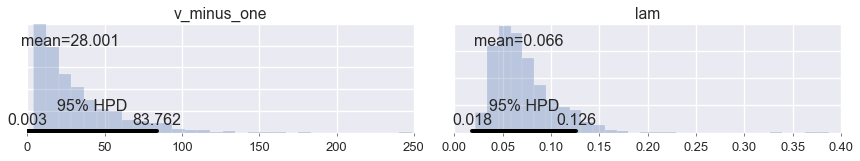

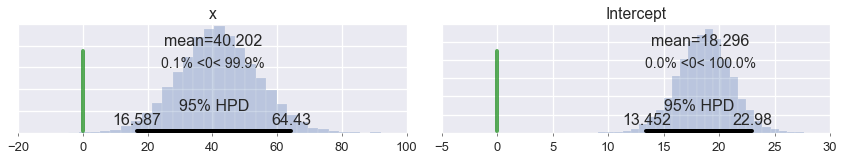

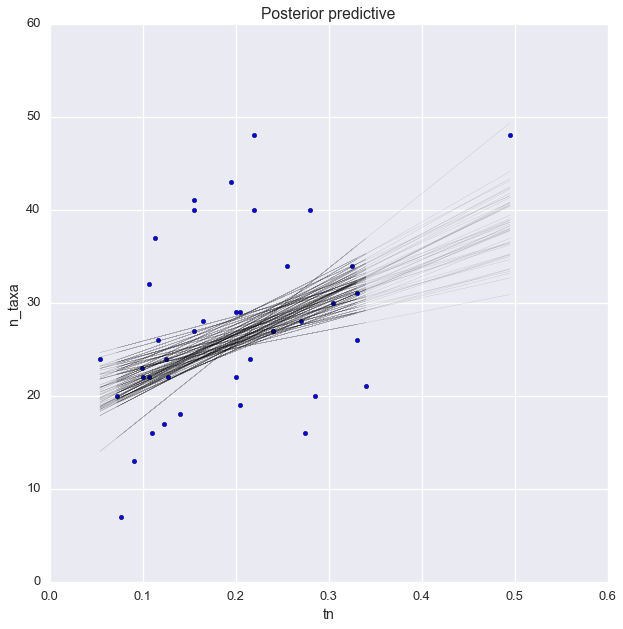

In [11]:
# Robust Bayesian regression
var_map = {'x':'tn',
           'y':'n_taxa'}

res = ecoreg.robust_lin_reg(df, var_map, plot_trace=False,
                            plot_vars=True, mcmc='slice', 
                            steps=10000)

These results agree very closely with the OLS results: there is more than 99% confidence that the slope and intercept parameters are different from 0, and the most likely parameter values are:

$$n_{taxa} = 40*tn + 18$$

##### Summary

Taken together, the different components of this regression analysis provide a fairly consistent picture: `tn` appears to be the only genuinely signifcant predictor of `n_taxa`, but there is some evidence that `cv` may be important too. Weaker evidence suggests that other variables such as `toc`, `mean` and `cond` may also play a role. What's more, the direction (sign) of the effects of these parameters are all more-or-less what we would expect from simple theory.

### 7.2. Other variables (working code)

The code below repeats the workflow from above. By modifying this code, I have applied the methodology described above for all response and explanatory variable combinations listed in the tables for Germany and Norway at the start of this notebook. 

I have also pooled the data for both countries and attempted to fit models to the full dataset. To do this, I have included `country` and `regulated` as binary explanatory variables, as it is clear from the previous analysis that different (but perhaps related) models are appropriate in each country. The variable combinations considered for the pooled data are:

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/regression_metrics_all.png?raw=true" alt="German regression metrics" width="450">


The results of all this processing are described and summarised in Section 8, below. The code cells in the remainder of this section are just "working examples" and can be skipped.

##### 1. Get data

In [97]:
cols = ['green_rich', 'tn', 'tp', 'toc', 'cond', 'mean', 'cv',
        'n_hi_pulse_yr', 'range', 'days_to_p05', 'days_to_p95',
        'revs_per_yr', 'country']#, 'regulated']
df = pd.concat([site_df, pb_df, hi_df], axis=1)[cols]

# Either filter by country or convert country label to boolean
df = df.query('country == "D"')
#df['country'] = pd.Categorical(df.country).labels

df.head()

,green_rich,tn,tp,toc,cond,mean,cv,n_hi_pulse_yr,range,days_to_p05,days_to_p95,revs_per_yr,country
107000582,3,2.39,20.0,3.71,380.0,13.136764,0.571753,2.666667,37.511344,730,539,149.666667,D
107000628,3,3.41,30.0,2.60,310.0,4.867736,1.135739,9.333333,68.590708,1,149,104.666667,D
107000671,1,6.10,114.0,4.01,539.0,0.624373,1.774661,10.000000,15.931536,446,21,108.333333,D
107001160,2,2.43,30.0,2.51,230.0,0.354208,1.316239,11.000000,5.599323,0,145,103.666667,D
107001168,4,5.31,100.0,2.46,462.5,2.185906,1.113433,7.666667,30.327750,0,58,119.000000,D


##### 2. Get variables and plot lasso path

In [98]:
print len(df)
df.dropna(how='any', inplace=True)
print len(df)
df.head()

25
25


,green_rich,tn,tp,toc,cond,mean,cv,n_hi_pulse_yr,range,days_to_p05,days_to_p95,revs_per_yr,country
107000582,3,2.39,20.0,3.71,380.0,13.136764,0.571753,2.666667,37.511344,730,539,149.666667,D
107000628,3,3.41,30.0,2.60,310.0,4.867736,1.135739,9.333333,68.590708,1,149,104.666667,D
107000671,1,6.10,114.0,4.01,539.0,0.624373,1.774661,10.000000,15.931536,446,21,108.333333,D
107001160,2,2.43,30.0,2.51,230.0,0.354208,1.316239,11.000000,5.599323,0,145,103.666667,D
107001168,4,5.31,100.0,2.46,462.5,2.185906,1.113433,7.666667,30.327750,0,58,119.000000,D


In [82]:
df.groupby('country').describe().xs('mean', level=1)

,cond,cv,days_to_p05,days_to_p95,ger_sap_idx,mean,n_hi_pulse_yr,range,regulated,revs_per_yr,tn,toc,tp
country,,,,,,,,,,,,,
0,342.261905,1.189355,225.142857,106.285714,1.802571,4.202137,8.182540,48.378339,0.428571,116.873016,3.456429,3.809524,99.654762
1,25.405659,1.204214,225.600000,70.900000,1.567525,14.113335,9.383333,144.272612,0.500000,120.425000,0.195525,2.518500,17.100000


In [100]:
# Lists of explan and resp vars
exp_vars = ['tn', 'tp', 'toc', 'cond', 'mean', 'cv', 'n_hi_pulse_yr',
            'range', 'days_to_p05', 'days_to_p95', 'revs_per_yr']#,
            #'country', 'regulated']
resp_var = 'green_rich'

# Plot lasso path
res_df, fig = ecoreg.plot_lasso_path(df, resp_var, exp_vars)

mpld3.display(fig)

##### 3. Plot refined lasso path

In [84]:
# Lists of explan and resp vars
exp_vars = ['cond', 'tn', 'n_hi_pulse_yr', 'country']
resp_var = 'ger_sap_idx'

# Plot lasso path
res_df, fig = ecoreg.plot_lasso_path(df, resp_var, exp_vars)

mpld3.display(fig)

##### 4. Find best lasso

LassoCV(alphas=None, copy_X=True, cv=61, eps=0.001, fit_intercept=False,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


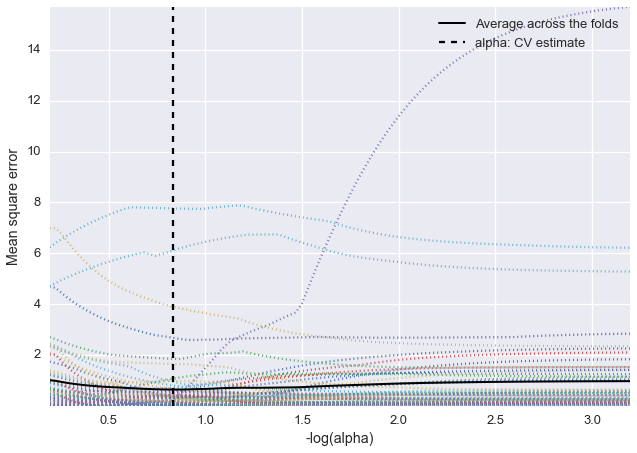

,0
tn,0.161591
tp,0.000000
toc,0.000000
cond,0.294639
mean,0.000000
cv,0.000000
n_hi_pulse_yr,-0.128857
range,0.000000
days_to_p05,-0.000000
days_to_p95,-0.000000


In [89]:
# Lists of explan and resp vars
exp_vars = ['tn', 'tp', 'toc', 'cond', 'mean', 'cv', 'n_hi_pulse_yr',
            'range', 'days_to_p05', 'days_to_p95', 'revs_per_yr',
            'country', 'regulated']
resp_var = 'ger_sap_idx'

params = ecoreg.best_lasso(df, resp_var, exp_vars, kcv=61, cv_path=True, hists=False)
params

##### 5. OLS for best lasso

In [102]:
mod_str = 'green_rich ~ cond + n_hi_pulse_yr'

# Regression. Pass alpha=0 for OLS. Larger alpha gives a bigger penalty on the
# size of the parameter estimates
model = smf.ols(mod_str, data=df).fit_regularized(alpha=0, l1_wt=0)

print model.summary()

                            OLS Regression Results                            
Dep. Variable:             green_rich   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     6.980
Date:                Tue, 07 Mar 2017   Prob (F-statistic):            0.00449
Time:                        14:53:22   Log-Likelihood:                -37.233
No. Observations:                  25   AIC:                             80.47
Df Residuals:                      22   BIC:                             84.12
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         6.6933      1.119      5.980

##### 6. Best subsets regression

In [101]:
# Best subsets regression
res = ecoreg.best_subsets(df, resp_var, exp_vars)

Regression results for the model with the lowest BIC:

                            OLS Regression Results                            
Dep. Variable:             green_rich   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     8.457
Date:                Tue, 07 Mar 2017   Prob (F-statistic):            0.00189
Time:                        14:51:54   Log-Likelihood:                -36.246
No. Observations:                  25   AIC:                             78.49
Df Residuals:                      22   BIC:                             82.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------

##### 7. Bayesian robust regression

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 517.73it/s]

Optimization terminated successfully.
         Current function value: 250.617648
         Iterations: 14
         Function evaluations: 23
         Gradient evaluations: 23


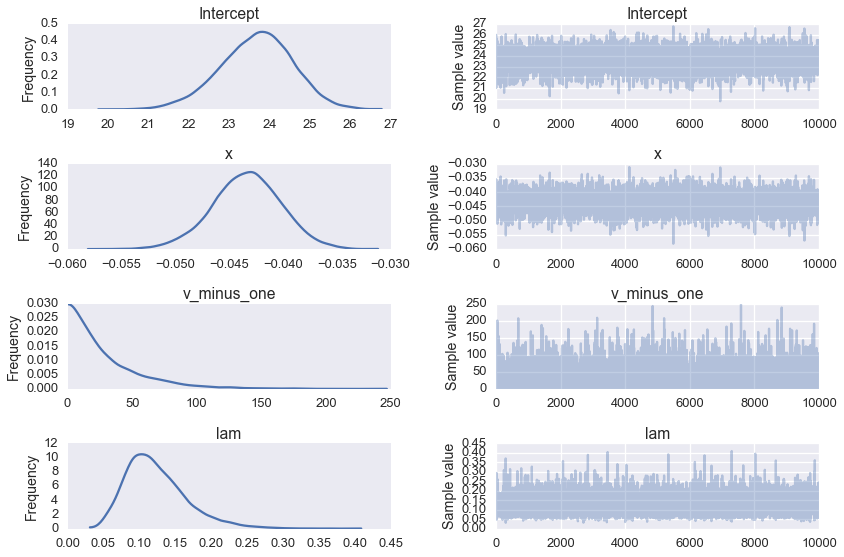

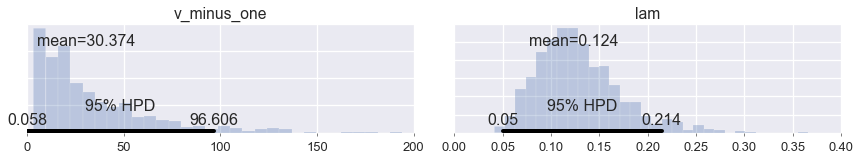

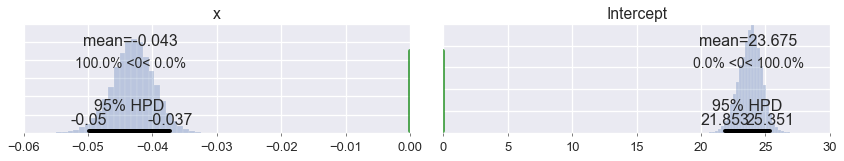

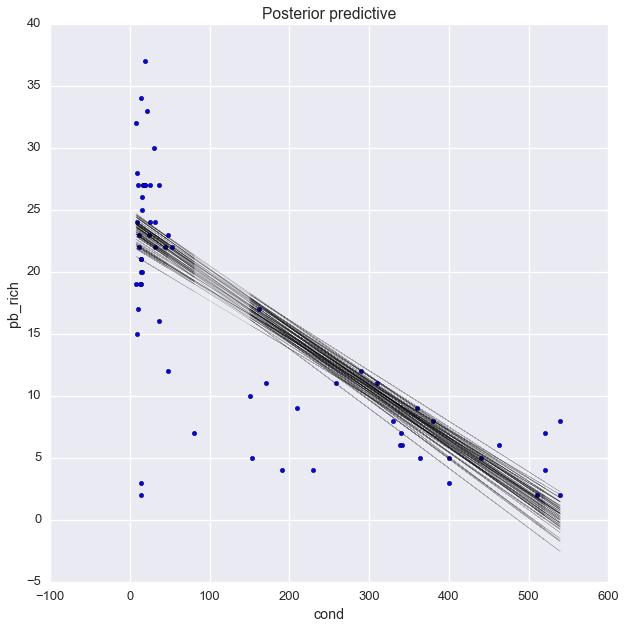

In [211]:
# Robust Bayesian regression
var_map = {'x':'cond',
           'y':'pb_rich'}

res = ecoreg.robust_lin_reg(df, var_map, plot_trace=True,
                            plot_vars=True, mcmc='slice', 
                            steps=10000)

## 8. Results

The Excel file here:

C:\Data\James_Work\Staff\Susi_S\ECOREG\regression_results_summary.xlsx

summarises the results, including details of the main regression relationships and comments to aid interpretation. A simplified summary appears in the tables below.

### 8.1. Norway

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/nor_reg_results.png?raw=true" alt="Norway regression results" width="600">

### 8.2. Germany

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/ger_reg_results.png?raw=true" alt="Germany regression results" width="600">

### 8.2. Norway and Germany combined

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/all_reg_results.png?raw=true" alt="Combined regression results" width="600">